### НИЯУ МИФИ. Лаботаторная работа #6. Полищук Максим, Б20-505

# Используемая система

```
CPU: 6-core 12th Gen Intel Core i5-12400F (-MCP-) speed: 2496 MHz
Kernel: 5.15.0-50-generic x86_64 Up: 45m Mem: 3491.6/9937.1 MiB (35.1%)
Storage: 71.31 GiB (20.1% used) Procs: 292 Shell: Zsh inxi: 3.3.13

MPI:
HYDRA build details:
    Version:                                 4.0
    Release Date:                            Fri Jan 21 10:42:29 CST 2022
```

# Код
```
#include <iostream>
#include <cstdlib>
#include <time.h>
#include "mpi.h"

using namespace std;

void shellSort(int* arr, int n)
{
    int stride = 0;
    for (stride = 1; stride < n / 3; stride = stride * 3 + 1);
    while(stride > 0)
    {
        for (int i = stride; i < n; i++)
        {
            int temp = arr[i];
            int j;
            for (j = i; j >= stride && arr[j - stride] > temp; j -= stride)
                arr[j] = arr[j - stride];

            arr[j] = temp;
        }
        stride = (stride - 1)/3;
    }
}


int main(int argc, char **argv) {
    int size, rank, arraySize = 1000000;
    int *array = new int[arraySize];
    const int random_seed = 920224;
    MPI_Status status;

    MPI_Init(&argc, &argv);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);

    srand(random_seed);

    if (rank == 0) {
        for (int i = 0; i < arraySize; i++) {
            array[i] = (rand() +rand() * RAND_MAX ) / 40;

        }
    }

    int *subArray;
    int n = arraySize / size;
    double begin;
    double end;

    if (rank == 0) {

        for (int i = 1; i < size; i++) {
            MPI_Send(array + n * (i - 1), n, MPI_INT, i, 0, MPI_COMM_WORLD);
        }

        begin = MPI_Wtime();
        int k = arraySize - n * (size - 1);
        subArray = new int[k];

        for (int i = n * (size - 1); i < arraySize; i++) {
            subArray[i - n * (size - 1)] = array[i];
        }
        shellSort(subArray, k);
        int *rArray = new int[arraySize];
        for (int i = 0; i < k; i++) {
            rArray[i] = subArray[i];
        }
        for (int i = 1; i < size; i++) {
            MPI_Recv(rArray + n * (i - 1) + k, n, MPI_INT, MPI_ANY_SOURCE, 1, MPI_COMM_WORLD, &status);
        }
        shellSort(rArray, arraySize);
        end = MPI_Wtime();
        cout << "" << (end - begin) << std::endl;
    }
    else
    {
        subArray = new int[n];
        MPI_Recv(subArray, n, MPI_INT, 0, 0, MPI_COMM_WORLD, &status);
        shellSort(subArray, n);
        MPI_Send(subArray, n, MPI_INT, 0, 1, MPI_COMM_WORLD);
    }

    MPI_Finalize();

    return 0;
}

```

In [1]:
# REFACTOR DEFAULT VALUES FOR YOUR SYSTEM
CORE_LIMIT = 16
OLD_CUT = 5
NEW_CUT = 5

In [2]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

old_arr, cur_arr = [], []

with open("old_trace.txt", "r") as fd:
    for _ in range(CORE_LIMIT):
        line = list(map(float, fd.readline().split(";")))
        line = sorted(line)[OLD_CUT:-OLD_CUT]
        avg_value = (sum(line) / len(line))
        old_arr.append(avg_value)
with open("trace.txt", "r") as fd:
    for i in range(CORE_LIMIT):
        line = list(map(float, fd.readline().split(";")))
        line = sorted(line)[NEW_CUT:-NEW_CUT]
        avg_value = (sum(line) / len(line))
        cur_arr.append(avg_value)


In [4]:
# Create DataFrames
old_predf = [[index+1, avg_time, "OpenMP"] for index, avg_time in enumerate(old_arr)]
cur_predf = [[index+1, avg_time, "MPI"] for index, avg_time in enumerate(cur_arr)]
old_df = pd.DataFrame(old_predf, columns=["Threads", "Time", "Type"])
cur_df = pd.DataFrame(cur_predf, columns=["Threads", "Time", "Type"])

all_df = pd.concat([old_df, cur_df])
# all_df

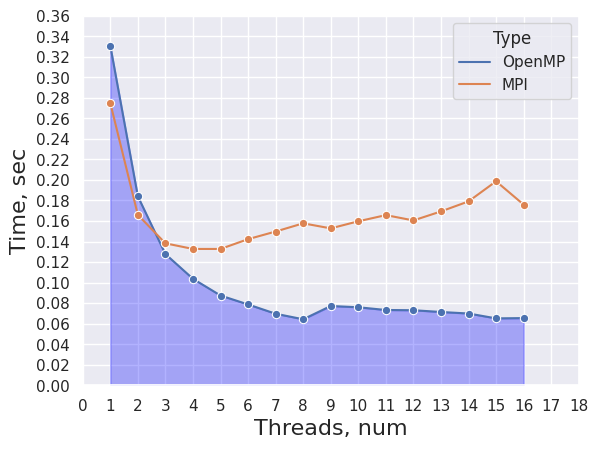

In [5]:
# Time(Thread) graph
p = sns.lineplot(x="Threads", y="Time", hue="Type", marker="o", data=all_df)
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("Time, sec", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
_ = p.fill_between(x1, y1, color="blue", alpha=0.3)
p.margins(x=0, y=0)
_ = p.set_xticks(range(0, CORE_LIMIT+3))
_ = p.set_xticklabels([str(i) for  i in range(CORE_LIMIT+3)])
_ = p.set_yticks([val*0.02 for val in range(19)])

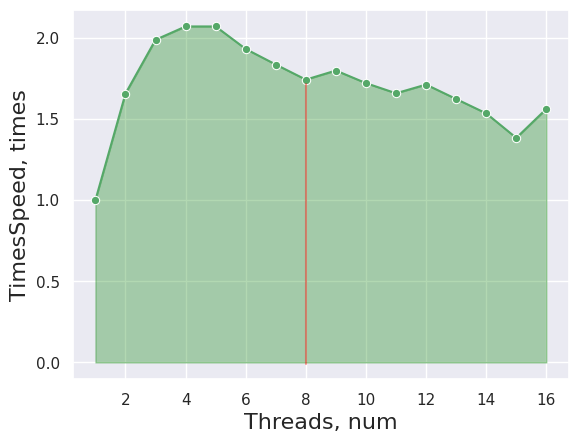

In [6]:
acceleration = [0] * CORE_LIMIT
for i in range(0, CORE_LIMIT):
    acceleration[i] = [i+1, (cur_arr[0]/cur_arr[i])]
    

a_df = pd.DataFrame(acceleration, columns=["Threads", "TimesSpeed"])
p = sns.lineplot(x="Threads", y="TimesSpeed", marker="o", data=a_df, color='g')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("TimesSpeed, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="green", alpha=0.3)
_ = p.axvline(x=8, ymin=0.04, ymax=0.8, color="red", alpha=0.4)

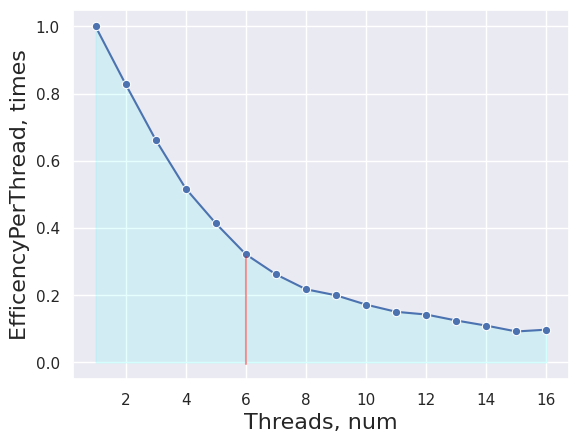

In [10]:
per_thread = [0] * CORE_LIMIT
for i in range(0, len(per_thread)):
    per_thread[i] = [acceleration[i][0], acceleration[i][1]/acceleration[i][0]]
thr_df = pd.DataFrame(per_thread, columns=["Threads", "EfficencyPerThread"])
p = sns.lineplot(x="Threads", y="EfficencyPerThread", marker="o", data=thr_df, color='b')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("EfficencyPerThread, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="cyan", alpha=0.1)
_ = p.axvline(x=6, ymin=0.04, ymax=0.33, color="red", alpha=0.4)

## Заключение

В этой работе я ознакомился с разработкой алгоритмов параллельной сортировки при помощи технологии **MPI**. Было проведено сравнение алгоритмов сортировки Шелла на **OpenMP** и **MPI**.

**Вывод:** Технология MPI всё ещё показывает сравнительно худший результат. Но поскольку алгоритм сортировки гораздо затратнее чем поиск максимального элемента (в предыдущей лабораторной работе), то можно сделать вывод, что для сортировок операции пересылки данных между потоками играют меньшую роль => технология MPI практичнее использовать для более трудозатратных операций.